In [38]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

from astroML.correlation import two_point, bootstrap_two_point

from astropy.table import Table

# we're going to use simple ML library to find nearest k neighbors to act on, 
# and to explore simple outlier detection
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

In [39]:
# from exoplanetarchive.ipac.caltech.edu
Efile = 'planets_2019.04.22_15.27.57.csv'

df = pd.read_csv(Efile, comment='#')
df.columns

Index(['pl_hostname', 'pl_letter', 'pl_name', 'pl_discmethod',
       'pl_controvflag', 'pl_pnum', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_orbincl', 'pl_orbinclerr1',
       'pl_orbinclerr2', 'pl_orbincllim', 'pl_bmassj', 'pl_bmassjerr1',
       'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_radj',
       'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_dens', 'pl_denserr1',
       'pl_denserr2', 'pl_denslim', 'pl_ttvflag', 'pl_kepflag', 'pl_k2flag',
       'pl_nnotes', 'ra_str', 'ra', 'dec_str', 'dec', 'st_dist', 'st_disterr1',
       'st_disterr2', 'st_distlim', 'st_optmag', 'st_optmagerr',
       'st_optmaglim', 'st_optband', 'gaia_gmag', 'gaia_gmagerr',
       'gaia_gmaglim', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim',
       'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st

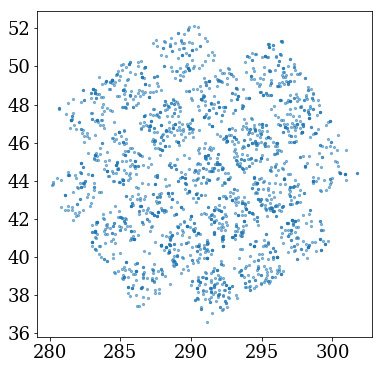

In [40]:
Kok = np.where((df['ra'] > 200) & (df['dec'] > 20))[0]

plt.figure(figsize=(6,6))
plt.scatter(df['ra'][Kok], df['dec'][Kok], s=5, alpha=0.5)

Text(0, 0.5, 'Fraction of Systems')

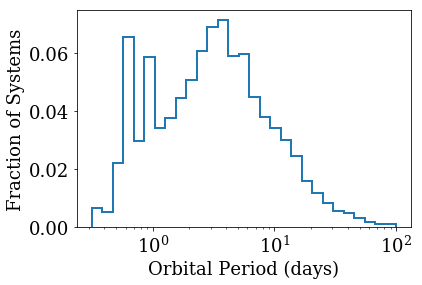

In [41]:
hh, bb, _ = plt.hist(df['pl_orbper'][Kok], bins=np.logspace(-0.5,2,30), normed=True, 
                     histtype='step', lw=2)
plt.xscale('log')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Fraction of Systems')

In [42]:
k=3

Text(0, 0.5, 'k=3 Odds (1 in N)')

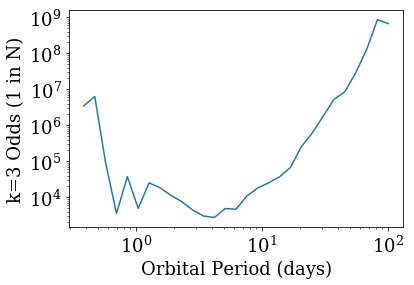

In [43]:
plt.plot(bb[1:], 1/(hh**k))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital Period (days)')
plt.ylabel('k='+str(k)+' Odds (1 in N)')
# plt.savefig('../figures/Kodds.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [44]:
bb[1:]

array([  0.38566204,   0.47034203,   0.57361525,   0.69956422,
         0.85316785,   1.04049831,   1.268961  ,   1.54758735,
         1.88739182,   2.30180731,   2.8072162 ,   3.42359796,
         4.17531894,   5.09209564,   6.21016942,   7.57373918,
         9.23670857,  11.26481692,  13.73823796,  16.75474919,
        20.43359718,  24.92021151,  30.39195382,  37.06512911,
        45.20353656,  55.12889789,  67.23357536,  81.99608245,
       100.        ])

In [45]:
print(1. / sum(1./(hh**k)[np.where((bb[1:] >= 50))[0]]))

5.99581104456524e-10


In [46]:
# prep coords
radec = np.vstack((df['ra'][Kok], df['dec'][Kok])).T

radec.shape

(2324, 2)

In [47]:
%%time
# use knn to figure out *which* stars are near eachother.
# we only have a couple thousand, so use brute force algorithm to ensure it's right
nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(radec)

# return distances and indicies of each neighbor 
kdist, kind = nbrs.kneighbors(radec)
kind.shape

CPU times: user 147 ms, sys: 29.8 ms, total: 176 ms
Wall time: 101 ms


In [48]:
# now use array index magic to get the periods for each cluster of k systems
kpers = np.reshape(df['pl_orbper'].values[Kok][np.ravel(kind)], kind.shape)

kpers.shape

(2324, 3)

In [49]:
kpers.max()

1322.3

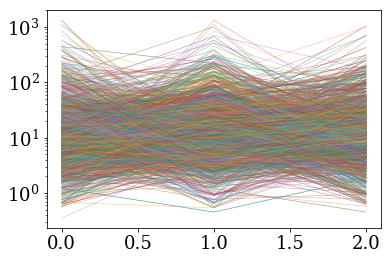

In [50]:
plt.plot(kpers.T, alpha=0.5, lw=0.5);
plt.yscale('log')

1217


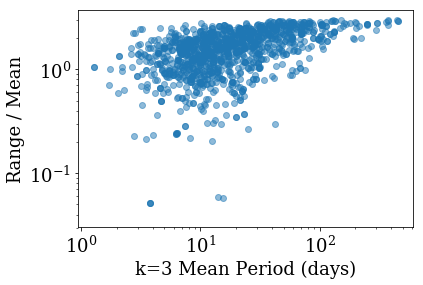

In [51]:
# only pick systems where the nearest-neighbor distances don't include multiplanet systems! 
# i.e. should only have 1 entry where the distance == 0 per cluster
ds = np.where((np.sum(kdist == 0, axis=1) == 1))[0]

# our "sameness" metric here is the stddev of the k periods, normalized to their mean
metric = ((np.max(kpers[ds,:], axis=1) - np.min(kpers[ds,:], axis=1)) / np.mean(kpers[ds,:], axis=1))

_ = plt.scatter(np.mean(kpers[ds,:], axis=1), metric, alpha=0.5)
plt.xscale("log")
plt.yscale('log')
plt.xlabel('k='+str(k)+' Mean Period (days)')
plt.ylabel('Range / Mean')

print(np.size(ds))

In [52]:
huh = np.argmin(metric) # the absolute lowest value
print(metric[huh])

0.05128275394719673


In [53]:
print(kpers[ds,:][huh], kdist[ds,:][huh], metric[huh])

[3.81371974 3.91795101 3.72215641] [0.         0.16188178 0.1650979 ] 0.05128275394719673


In [54]:
df['pl_hostname'].values[Kok][kind[ds[huh],:]]

array(['Kepler-1295', 'Kepler-1612', 'Kepler-612'], dtype=object)

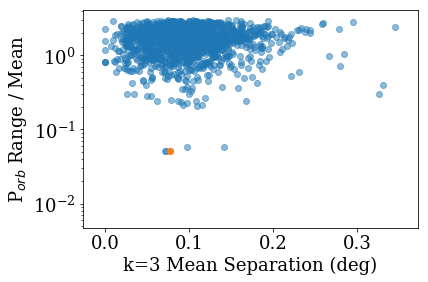

In [55]:
plt.scatter(np.sqrt(np.sum(kdist[ds,:]**2, axis=1))/k, metric, alpha=0.5)
plt.scatter(np.sqrt(np.sum(kdist[ds,:]**2, axis=1))[huh]/k, metric[huh])
plt.xlabel('k='+str(k)+' Mean Separation (deg)')
plt.ylabel('P$_{orb}$ Range / Mean')
plt.yscale('log')


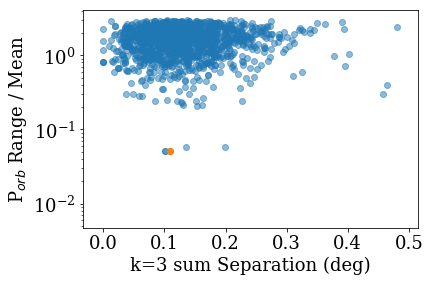

In [56]:
plt.scatter(np.sum(kdist[ds,:], axis=1)/k, metric, alpha=0.5)
plt.scatter(np.sum(kdist[ds,:], axis=1)[huh]/k, metric[huh])
plt.xlabel('k='+str(k)+' sum Separation (deg)')
plt.ylabel('P$_{orb}$ Range / Mean')
plt.yscale('log')



In [57]:
Mlim = 0.1
huh2 = np.where((metric < Mlim))[0]
huh2

array([ 298,  501,  605,  835, 1007])

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Period Range / Mean')

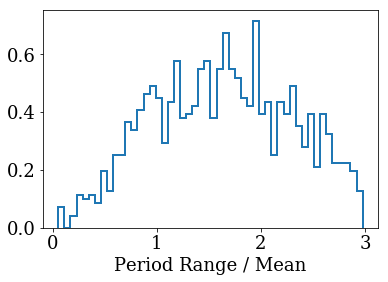

In [58]:
_ = plt.hist(metric, bins=50, lw=2, histtype='step', normed=True)
plt.xlabel('Period Range / Mean')


## QUESTION:
how to get rid of redundant clusters?

In [59]:
def define_circle(RAs, DECs):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    
    MODIFIED FROM: https://stackoverflow.com/a/50974391
    """
    p1 = [RAs[0], DECs[0]]
    p2 = [RAs[1], DECs[1]]
    p3 = [RAs[2], DECs[2]]
    
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-9:
        return (None, np.inf)

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

In [60]:
def compute_seps(RAs, DECs):
    ra_0 = np.nanmean(RAs)
    de_0 = np.nanmean(DECs)
    
    dists = np.sqrt((RAs - ra_0)**2 + (DECs - de_0)**2)
    return dists

In [61]:
define_circle(df['ra'].values[Kok][kind[ds[huh],:]], df['dec'].values[Kok][kind[ds[huh],:]])

((291.3406343040995, 45.65856637528743), 0.09042273324501068)

In [62]:
for j in range(len(huh2)):
    print()
    print(metric[huh2[j]])
#     df['pl_hostname'][Kok][kind[ds[huh],:]]
    print(df['pl_hostname'].values[Kok][kind[ds[huh2[j]],:]])
    print('periods:', kpers[ds,:][huh2[j]])
#     print('separations:', kdist[ds,:][huh2[j]])
    print('radius:', define_circle(df['ra'].values[Kok][kind[ds[huh2[j]],:]], 
                                   df['dec'].values[Kok][kind[ds[huh2[j]],:]])[1])
    print('separations', compute_seps(df['ra'].values[Kok][kind[ds[huh2[j]],:]], 
                                          df['dec'].values[Kok][kind[ds[huh2[j]],:]]))


0.05128275394719673
['Kepler-1295' 'Kepler-1612' 'Kepler-612']
periods: [3.81371974 3.91795101 3.72215641]
radius: 0.09042273324501068
separations [0.09855565 0.08443824 0.08648902]

0.0581010695490961
['Kepler-1507' 'Kepler-982' 'Kepler-1392']
periods: [16.0506213 15.7738221 15.1410397]
radius: 0.8351845978131902
separations [0.03560389 0.18435373 0.2164716 ]

0.05128275394719673
['Kepler-1612' 'Kepler-612' 'Kepler-1295']
periods: [3.91795101 3.72215641 3.81371974]
radius: 0.09042273320817873
separations [0.08443824 0.08648902 0.09855565]

0.05128275394719673
['Kepler-612' 'Kepler-1612' 'Kepler-1295']
periods: [3.72215641 3.91795101 3.81371974]
radius: 0.09042273324000585
separations [0.08648902 0.08443824 0.09855565]

0.058491616948908344
['Kepler-790' 'Kepler-473' 'Kepler-543']
periods: [13.73469807 14.55731705 13.89961966]
radius: 1.373485989931823
separations [0.02177515 0.29650898 0.29835557]


In [63]:
np.mean([3.81371974, 3.91795101, 3.72215641])

3.8179423866666666

In [64]:
len(ds)

1217

In [65]:
# compute the radii of circles going thru the k=3 cluster of points
rads = np.zeros(len(ds))
seps = np.zeros(len(ds))
for j in range(len(ds)):
    rads[j] = define_circle(df['ra'].values[Kok][kind[ds[j],:]], df['dec'].values[Kok][kind[ds[j],:]])[1]
    seps[j] = np.nanmean(compute_seps(df['ra'].values[Kok][kind[ds[j],:]], df['dec'].values[Kok][kind[ds[j],:]]))

In [66]:
# # fig based on example: https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

# # Set up the axes with gridspec
# fig = plt.figure(figsize=(6, 6))
# grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
# main_ax = fig.add_subplot(grid[1:,:-1])
# y_hist = fig.add_subplot(grid[1:,-1], sharey=main_ax, xticklabels=[])
# x_hist = fig.add_subplot(grid[0,:-1], sharex=main_ax, yticklabels=[])

# x_hist.xaxis.set_tick_params(labelbottom=False)
# y_hist.yaxis.set_tick_params(labelbottom=False)

# # scatter points on the main axes
# main_ax.plot(np.sqrt(np.sum(kdist[ds,:]**2, axis=1))/k, metric, 
#              alpha=0.35, markersize=3, marker='o', linestyle='none', c='k')

# main_ax.plot(np.sqrt(np.sum(kdist[ds,:][huh2]**2, axis=1))/k, metric[huh2], 
#              alpha=1, markersize=6, marker='o', linestyle='none', c='r')

# main_ax.text(0.3 , max(metric)-0.15 ,'k='+str(k), fontsize=14)
# main_ax.set_xlabel('Mean Separation (deg)')
# main_ax.set_ylabel('P$_{orb}$ Range / Mean')

# # histograms on the attached axes
# _ = x_hist.hist(np.sqrt(np.sum(kdist[ds,:]**2, axis=1))/k, 40, 
#                 histtype='step', orientation='vertical', normed=True, lw=2, color='k')
# _ = y_hist.hist(metric, 40, histtype='step', orientation='horizontal', normed=True, 
#                 lw=2, color='k')
# # plt.savefig('../figures/Kplanets.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

0.26674339562849525


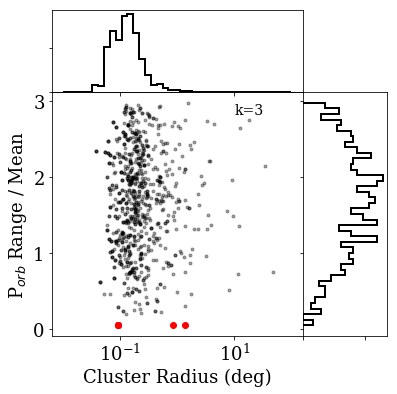

In [67]:
# fig based on example: https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
main_ax = fig.add_subplot(grid[1:,:-1])
y_hist = fig.add_subplot(grid[1:,-1], sharey=main_ax, xticklabels=[])
x_hist = fig.add_subplot(grid[0,:-1], sharex=main_ax, yticklabels=[])

x_hist.xaxis.set_tick_params(labelbottom=False)
y_hist.yaxis.set_tick_params(labelbottom=False)

# scatter points on the main axes
main_ax.plot(rads, metric, 
             alpha=0.35, markersize=3, marker='o', linestyle='none', c='k')

main_ax.plot(rads[huh2], metric[huh2], 
             alpha=1, markersize=6, marker='o', linestyle='none', c='r')

main_ax.set_xlabel('Cluster Radius (deg)')
main_ax.set_ylabel('P$_{orb}$ Range / Mean')
main_ax.set_xscale('log')

# histograms on the attached axes
_ = x_hist.hist(rads[np.isfinite(rads)], bins=np.logspace(-2,2,40), 
                histtype='step', orientation='vertical', normed=True, lw=2, color='k')
_ = y_hist.hist(metric[np.isfinite(rads)], 40, histtype='step', orientation='horizontal', normed=True, 
                lw=2, color='k')

main_ax.text(10 , max(metric)-0.15 ,'k='+str(k), fontsize=14)

# plt.savefig('../figures/./Kplanets.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

print(np.nanmedian(rads))

0.10956376144101983


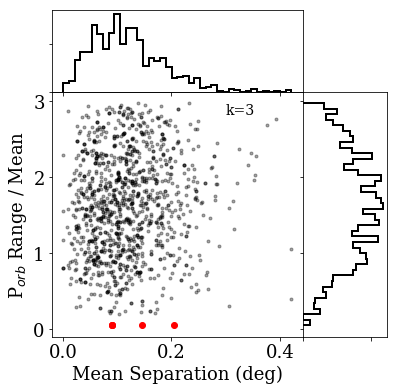

In [68]:
# fig based on example: https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
main_ax = fig.add_subplot(grid[1:,:-1])
y_hist = fig.add_subplot(grid[1:,-1], sharey=main_ax, xticklabels=[])
x_hist = fig.add_subplot(grid[0,:-1], sharex=main_ax, yticklabels=[])

x_hist.xaxis.set_tick_params(labelbottom=False)
y_hist.yaxis.set_tick_params(labelbottom=False)

# scatter points on the main axes
main_ax.plot(seps, metric, 
             alpha=0.35, markersize=3, marker='o', linestyle='none', c='k')

main_ax.plot(seps[huh2], metric[huh2], 
             alpha=1, markersize=6, marker='o', linestyle='none', c='r')

main_ax.set_xlabel('Mean Separation (deg)')
main_ax.set_ylabel('P$_{orb}$ Range / Mean')
# main_ax.set_xscale('log')

# histograms on the attached axes
_ = x_hist.hist(seps, 40, #bins=np.logspace(-2,2,40), 
                histtype='step', orientation='vertical', normed=True, lw=2, color='k')
_ = y_hist.hist(metric, 40, histtype='step', orientation='horizontal', normed=True, 
                lw=2, color='k')

main_ax.text(0.3 , max(metric)-0.15 ,'k='+str(k), fontsize=14)

plt.savefig('../figures/Kplanets.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

print(np.nanmedian(seps))

In [69]:
print(seps[np.argmin(metric)])

0.08982763534079803


In [70]:
print(np.nanmean(seps))

0.1175620859885484


In [71]:
print(np.min(metric))

0.05128275394719673


In [72]:
print(np.mean(metric), np.std(metric))

1.6337032532399591 0.6639575896039839


In [73]:
(np.mean(metric) - np.min(metric)) / np.std(metric)

2.3833156274884875

/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


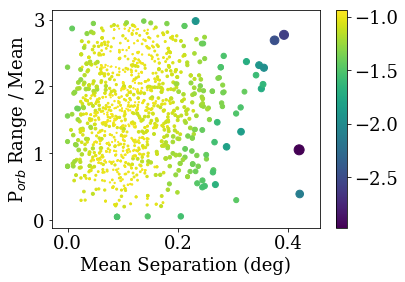

In [91]:
# now play around for 1 second w/ outlier detection...
Xmetrics = np.vstack((seps, metric)).T

clf = LocalOutlierFactor(novelty=False)
y_pred = clf.fit_predict(Xmetrics)

X_scores = clf.negative_outlier_factor_

radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

plt.scatter(seps, metric, c=X_scores, s = 100*radius)
plt.xlabel('Mean Separation (deg)')
plt.ylabel('P$_{orb}$ Range / Mean')
cb = plt.colorbar()

2
min metric:  1.8502658669272518
['Kepler-568' 'Kepler-919']
periods:  [11.02347475 11.04603384]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


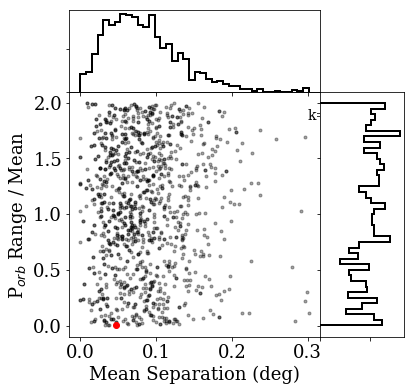

3
min metric:  2.3833156274884875
['Kepler-1295' 'Kepler-1612' 'Kepler-612']
periods:  [3.81371974 3.91795101 3.72215641]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


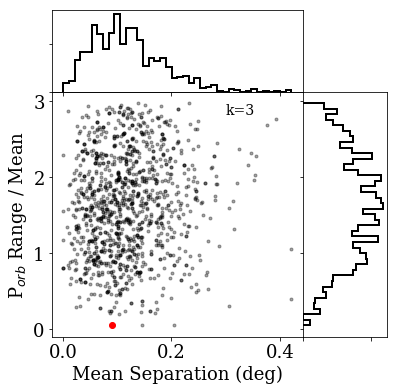

4
min metric:  2.4274782527897187
['Kepler-1048' 'Kepler-601' 'Kepler-1174' 'Kepler-583']
periods:  [6.92101021 5.37886844 6.89225223 6.5100253 ]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


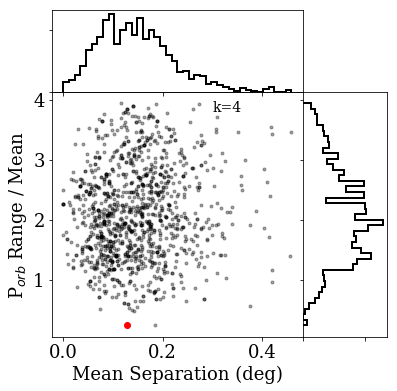

5
min metric:  2.4552430323676626
['Kepler-583' 'Kepler-601' 'Kepler-829' 'Kepler-1048' 'Kepler-1174']
periods:  [6.5100253  5.37886844 6.88337562 6.92101021 6.89225223]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


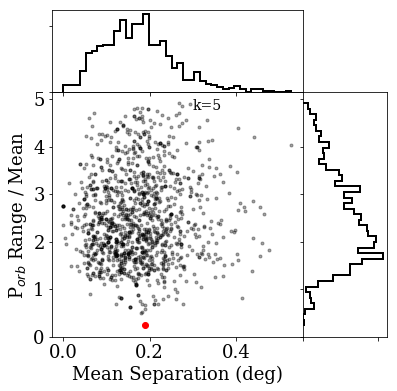

6
min metric:  2.4106486022091675
['Kepler-583' 'Kepler-601' 'Kepler-829' 'Kepler-1048' 'Kepler-1174'
 'Kepler-144']
periods:  [6.5100253  5.37886844 6.88337562 6.92101021 6.89225223 5.885273  ]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


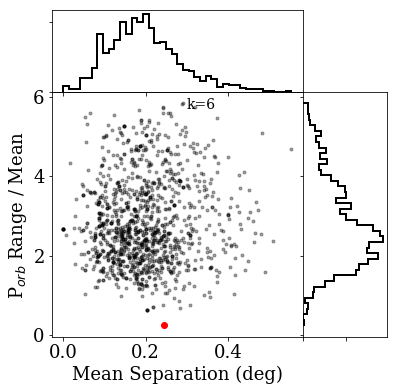

7
min metric:  2.0391568104875764
['Kepler-465' 'Kepler-735' 'Kepler-1074' 'Kepler-484' 'Kepler-504'
 'Kepler-1274' 'Kepler-864']
periods:  [ 9.94067247 11.51516988  5.94566534 10.04556931  9.54927542  6.98152703
  5.83376092]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


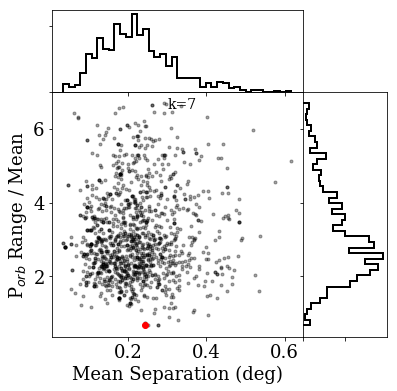

In [93]:
# now explore a range of k values a bit...

for k in range(2,8):
    print(k)
    # use knn to figure out *which* stars are near eachother.
    # we only have a couple thousand, so use brute force algorithm to ensure it's right
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(radec)

    # return distances and indicies of each neighbor 
    kdist, kind = nbrs.kneighbors(radec)

    # now use array index magic to get the periods for each cluster of k systems
    kpers = np.reshape(df['pl_orbper'].values[Kok][np.ravel(kind)], kind.shape)

    # only pick systems where the nearest-neighbor distances don't include multiplanet systems! 
    # i.e. should only have 1 entry where the distance == 0 per cluster
    ds = np.where((np.sum(kdist == 0, axis=1) == 1))[0]

    # our "sameness" metric here is the stddev of the k periods, normalized to their mean
    metric = ((np.max(kpers[ds,:], axis=1) - np.min(kpers[ds,:], axis=1)) / np.mean(kpers[ds,:], axis=1))

    huh = np.argmin(metric) # the absolute lowest value


    # compute the radii of circles going thru the k=3 cluster of points
    seps = np.zeros(len(ds))
    for j in range(len(ds)):
        seps[j] = np.nanmean(compute_seps(df['ra'].values[Kok][kind[ds[j],:]], df['dec'].values[Kok][kind[ds[j],:]]))

    print('min metric: ',(np.mean(metric) - np.min(metric)) / np.std(metric))

    print(df['pl_hostname'].values[Kok][kind[ds[huh],:]])
    print('periods: ', df['pl_orbper'].values[Kok][kind[ds[huh],:]])

    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
    main_ax = fig.add_subplot(grid[1:,:-1])
    y_hist = fig.add_subplot(grid[1:,-1], sharey=main_ax, xticklabels=[])
    x_hist = fig.add_subplot(grid[0,:-1], sharex=main_ax, yticklabels=[])

    x_hist.xaxis.set_tick_params(labelbottom=False)
    y_hist.yaxis.set_tick_params(labelbottom=False)

    # scatter points on the main axes
    main_ax.plot(seps, metric, 
                 alpha=0.35, markersize=3, marker='o', linestyle='none', c='k')

    main_ax.plot(seps[huh], metric[huh], 
                 alpha=1, markersize=6, marker='o', linestyle='none', c='r')

    main_ax.set_xlabel('Mean Separation (deg)')
    main_ax.set_ylabel('P$_{orb}$ Range / Mean')
    # main_ax.set_xscale('log')

    # histograms on the attached axes
    _ = x_hist.hist(seps, 40, #bins=np.logspace(-2,2,40), 
                    histtype='step', orientation='vertical', normed=True, lw=2, color='k')
    _ = y_hist.hist(metric, 40, histtype='step', orientation='horizontal', normed=True, 
                    lw=2, color='k')

    main_ax.text(0.3 , max(metric)-0.15 ,'k='+str(k), fontsize=14)
    plt.show()